<a href="https://colab.research.google.com/github/mshadabgithub/DNN/blob/main/Anomaly_Detection_For_Time_Based_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################ This will not change the output of tensorflow model ####################
seed_value = 77
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [3]:
print(dataframe.shape)
print(dataframe[dataframe[140]==1].shape)
train_data_1 = dataframe[dataframe[140]==1]
train_data_0 = dataframe[dataframe[140]==0]

(4998, 141)
(2919, 141)


In [4]:
# The last element contains the labels
#labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = train_data_0.iloc[:, 0:-2]

train_data, test_data = train_test_split(
    data, test_size=0.05, random_state=21
)

In [5]:
min_val = train_data.min()
max_val = train_data.max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

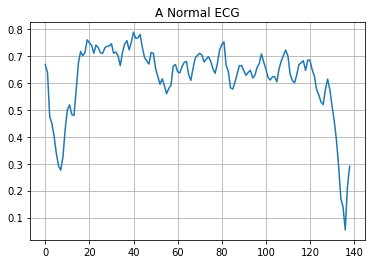

In [6]:
plt.grid()
plt.plot(np.arange(139), train_data[0])
plt.title("A Normal ECG")
plt.show()

In [7]:
print(train_data.shape)
train_data = tf.reshape(train_data, [train_data.shape[0], 1, train_data.shape[1]])
test_data = tf.reshape(test_data, [test_data.shape[0], 1, test_data.shape[1]])
print(train_data.shape)
print(test_data.shape)

(1975, 139)
(1975, 1, 139)
(104, 1, 139)


In [8]:
encoder_input = keras.Input(shape=(train_data.shape[1], train_data.shape[2]))
encoder1 = keras.layers.LSTM(64, return_sequences=True, activation="relu")(encoder_input)
encoder2 = keras.layers.LSTM(32, return_sequences=False, activation="relu")(tf.reshape(encoder1, [-1, 1, 64]))

#encoder_output = keras.layers.RepeatVector(train_data.shape[1])(encoder2)

encoder = keras.Model(encoder_input, encoder2, name="encoder")

decoder_input1 = keras.layers.LSTM(32, return_sequences=True, activation="relu")(tf.reshape(encoder2, [-1, 1, 32]))
decoder_output = keras.layers.LSTM(train_data.shape[2])(decoder_input1)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 139)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             52224     
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 139)               

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

In [10]:
history = autoencoder.fit(train_data, train_data, 
                          epochs=20, 
                          batch_size=256,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
8/8 [==============================] - 6s 192ms/step - loss: 0.6188 - val_loss: 0.6175
Epoch 2/20
8/8 [==============================] - 1s 78ms/step - loss: 0.6167 - val_loss: 0.6152
Epoch 3/20
8/8 [==============================] - 1s 74ms/step - loss: 0.6138 - val_loss: 0.6109
Epoch 4/20
8/8 [==============================] - 1s 76ms/step - loss: 0.6060 - val_loss: 0.5936
Epoch 5/20
8/8 [==============================] - 1s 79ms/step - loss: 0.5648 - val_loss: 0.4944
Epoch 6/20
8/8 [==============================] - 1s 74ms/step - loss: 0.3919 - val_loss: 0.2341
Epoch 7/20
8/8 [==============================] - 1s 75ms/step - loss: 0.1606 - val_loss: 0.1050
Epoch 8/20
8/8 [==============================] - 1s 74ms/step - loss: 0.1006 - val_loss: 0.0919
Epoch 9/20
8/8 [==============================] - 1s 78ms/step - loss: 0.0853 - val_loss: 0.0732
Epoch 10/20
8/8 [==============================] - 1s 74ms/step - loss: 0.0685 - val_loss: 0.0618
Epoch 11/20
8/8 [===========

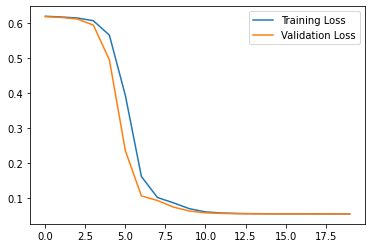

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

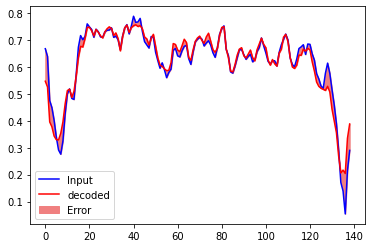

In [12]:
decoded_data = autoencoder(train_data).numpy()

plt.plot(train_data[0].numpy().flatten(), 'b')
plt.plot(decoded_data[0].flatten(), 'r')
plt.fill_between(np.arange(139), decoded_data[0].flatten(), train_data[0].numpy().flatten(), color='lightcoral')
plt.legend(labels=["Input", "decoded", "Error"])
plt.show()

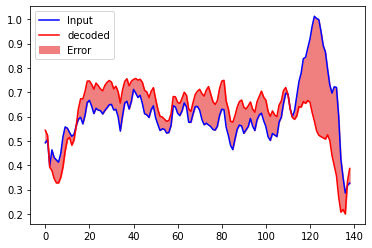

In [13]:
decoded_data = autoencoder(test_data).numpy()

plt.plot(test_data[0].numpy().flatten(), 'b')
plt.plot(decoded_data[0].flatten(), 'r')
plt.fill_between(np.arange(139), decoded_data[0].flatten(), test_data[0].numpy().flatten(), color='lightcoral')
plt.legend(labels=["Input", "decoded", "Error"])
plt.show()

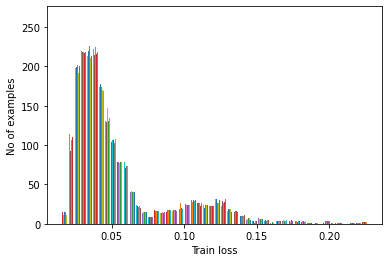

In [14]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss.numpy(), bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [15]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.088360846


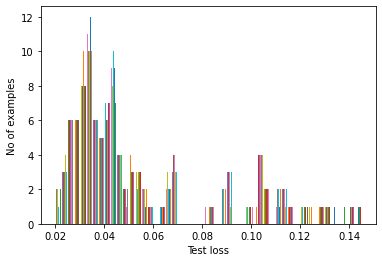

In [16]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss.numpy(), bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
data_test = train_data_1.iloc[:, 0:-2]
test_1 = tf.reshape(data_test, [data_test.shape[0], 1, data_test.shape[1]])
decoded_1 = autoencoder.predict(test_1)
test_loss4_1 = tf.keras.losses.mae(decoded_1, test_1)

plt.hist(test_loss4_1.numpy(), bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()